In [8]:
import numpy as np
import os, sys, librosa, math
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import IPython.display as ipd
import pandas as pd
import librosa, librosa.display

from utils.feature_tools import normalize_feature_sequence, smooth_downsample_feature_sequence, median_downsample_feature_sequence
from utils.plot_tools import plot_matrix, compressed_gray_cmap, plot_chromagram
from utils.structure_tools import *

# Audio Thumbnailing

- 음악 구조 분석의 두드러진 하위 문제는 **오디오 썸네일링(thumbnailing)** 으로 알려져 있다. 
- 음악 녹음에서 목적은 가장 대표적인 섹션을 자동으로 결정하는 것이며, 이는 청취자에게 노래 또는 음악 작품에 대한 첫인상을 주는 일종의 "미리 보기" 역할을 할 수 있다. 
- 이러한 미리 보기를 기반으로 사용자는 노래를 듣고 싶은지 또는 다음 녹음으로 이동할지 빠르게 결정할 수 있어야 한다. 
- 따라서 오디오 썸네일은 대규모 음악 컬렉션에서 흥미로운 부분을 찾는 데 중요한 탐색 및 탐색 보조 도구이다. 이 노트북에서는 **반복 기반 접근 방식(repetition-based approach)** 을 설명한다.

- 종종 후렴구 또는 노래의 메인 테마와 같은 섹션은 오디오 썸네일의 좋은 후보이다. 이러한 부분은 일반적으로 녹음 내내 여러 번 반복된다. 
- 따라서 썸네일을 자동으로 결정하기 위해 대부분의 절차는 한편으로는 특정 최소 기간이 있고 다른 한편으로는 **많은 (대략적인) 반복**이 있는 섹션을 식별한다. 
- 다음 그림은 서양 음악에서 볼 수 있는 음악 구조의 몇 가지 예를 보여준다. 
    - 론도는 당연히 썸네일 후보가 테마(A파트)입니다. 소나타에서 제시부의 시작 부분(파트 E1, E2 및 R에서 발생)은 적절한 축소판일 수 있다. '예스터데이'와 같은 팝송은 벌스 섹션(V1 파트)이 특징이다. 마지막으로 이전 노트북에서 실행 예제로 이미 봤던 Brahms 예제에서 A 파트 또는 B 파트를 썸네일로 선택할 수 있다.

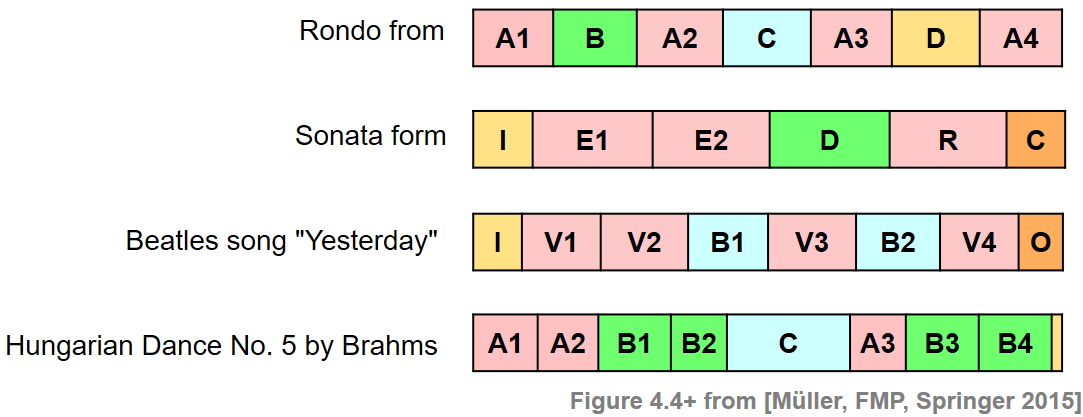

In [3]:
ipd.Image("../img/5.music_structure_analysis/FMP_C4_F04+.png", width=500)

- 한 가지 문제는 반복되는 섹션이 다이나믹(dynamics), 악기 편성, 아티큘레이션 및 템포와 관련된 측면에서 상당한 음향 및 음악적 차이를 보일 수 있다는 것이다. 
- 따라서 주어진 음악 녹음에서 반복적인 세그먼트를 추출하기 위한 썸네일링 절차는 특정 변형에 robust해야 한다. 

- 이제 음악적, 템포적인 변동을 다루기 위해, 향상된 자기 유사성 행렬(SSM)과 타임 워핑(time warping) 기술을 기반으로 하는 절차를 설명한다. 주요 기술 도구로 각 오디오 세그먼트에 적합도(fitness) 값을 할당하는 **fitness measure**를 소개한다. 이 측정은 두 가지 측면을 동시에 포착한다. 첫째, 주어진 세그먼트가 다른 관련 세그먼트를 **얼마나 잘** 설명하는지를 나타내고, 둘째, 이러한 모든 관련 세그먼트가 전체 음악 녹음의 **얼마나 많은** 부분을 포함하는지 나타낸다. 그런 다음 **오디오 썸네일**은 **최대 피트니스 세그먼트**로 정의된다.

## Requirements on SSM

- 적합도(fitness) 측정의 아이디어는 주어진 세그먼트와 그것의 대략적인 반복 간의 모든 관계를 동시에 설정하는 것이다. 이를 위해서는 **자기 유사성 행렬(SSM)** 이 필요하다. 적합도 측정에 대한 다음 설명은 일부 기본 **정규화 속성(normalization properties)** 만 충족하는 일반 자기 유사성 행렬과 함께 작동한다는 점에서 일반적이다. 
- $ \mathbf{S}(n,m)\leq 1$ and $\mathbf{S}(n,n)=1$ for all $n,m\in[1:N]$


- 5.2.에서 사용한 브람스 예시를 계속하여, 향상된(enhanced) SSM에서 시작하여 정규화 속성을 만족시키는 임계값 절차(thresholding procedure)을 거친다. 결과적으로 SSM의 모든 관련된(relevant) 성분은 0과 1 사이(주대각선 성분은 1)가 되며, 관련없는 성분은 $\delta=-2$의 음수 점수를 가진다.

In [7]:
def colormap_penalty(penalty=-2, cmap=compressed_gray_cmap(alpha=5)):
    """Extend colormap with white color between the penalty value and zero

    Notebook: C4/C4S3_AudioThumbnailing.ipynb

    Args:
        penalty (float): Negative number (Default value = -2.0)
        cmap (mpl.colors.Colormap): Original colormap (Default value = libfmp.b.compressed_gray_cmap(alpha=5))

    Returns:
        cmap_penalty (mpl.colors.Colormap): Extended colormap
    """
    if isinstance(cmap, str):
        cmap = matplotlib.cm.get_cmap(cmap, 128)
    cmap_matrix = cmap(np.linspace(0, 1, 128))[:, :3]
    num_row = int(np.abs(penalty)*128)
    # cmap_penalty = np.flip(np.concatenate((cmap_matrix, np.ones((num_row, 3))), axis=0), axis=0)
    cmap_penalty = np.concatenate((np.ones((num_row, 3)), cmap_matrix), axis=0)
    cmap_penalty = ListedColormap(cmap_penalty)

    return cmap_penalty


def normalization_properties_ssm(S):
    """Normalizes self-similartiy matrix to fulfill S(n,n)=1.
    Yields a warning if max(S)<=1 is not fulfilled

    Notebook: C4/C4S3_AudioThumbnailing.ipynb

    Args:
        S (np.ndarray): Self-similarity matrix (SSM)

    Returns:
        S_normalized (np.ndarray): Normalized self-similarity matrix
    """
    S_normalized = S.copy()
    N = S_normalized.shape[0]
    for n in range(N):
        S_normalized[n, n] = 1
        max_S = np.max(S_normalized)
    if max_S > 1:
        print('Normalization condition for SSM not fulfill (max > 1)')
    return S_normalized

In [9]:
tempo_rel_set = compute_tempo_rel_set(0.66, 1.5, 5)
penalty = -2

import audioread
fn_mp3 = audioread.ffdec.FFmpegAudioFile('../audio/brahms_hungarian_dance_5.mp3')

x, x_duration, X, Fs_feature, S, I = compute_sm_from_filename(fn_mp3, L=21, H=5, 
                        L_smooth=12, tempo_rel_set=tempo_rel_set, penalty=penalty, thresh= 0.15)
S = normalization_properties_ssm(S)
 
cmap_penalty = colormap_penalty(penalty=penalty)

C:\Users\Cho\Documents\GitHub\mir\Notebooks\5. Music Structure Analysis\utils\structure_tools.py:293: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  x, Fs = librosa.load(fn_wav, Fs)


In [17]:
S.shape

(456, 456)

(None,
 [<AxesSubplot: xlabel='Time (frames)'>, <AxesSubplot: >],
 <matplotlib.image.AxesImage at 0x24919ca75e0>)

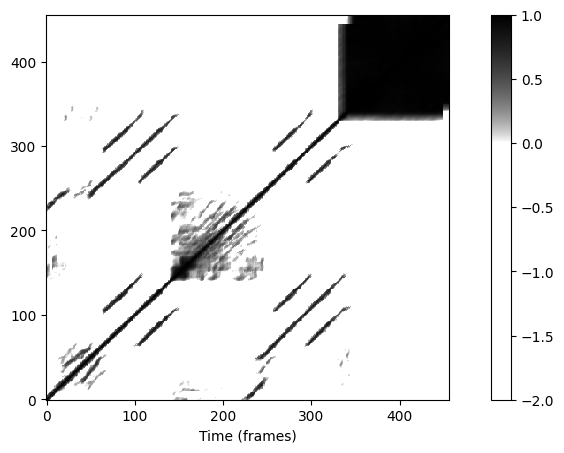

In [28]:
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 0.05]}, figsize=(6,5))

plot_matrix(S, Fs=1, Fs_F=1, ax = [axs[0],axs[1]], cmap=cmap_penalty,
                          xlabel='Time (frames)', ylabel='', title='')

## Path Family

- $P=((n_1,m_1), (n_2,m_2), \ldots,(n_L,m_L))$를 주어진 **세그먼트** $\alpha=[s:t]\subseteq [ 1:N]$의 경로(path)라고 하고, $\Sigma$를 기본 **허용 가능한 step size 집합**을 나타낸다고 하자. 
- 그러면 정의에 따라 $m_1=s$ 및 $m_L=t$가 있고, 경로 $P$는 $\alpha=\pi_2(P)$와 induced 세그먼트 $\pi_1(P)$ 사이의 관계를 인코딩한다. 

- 경로의 개념을 확장하여 이제 음악 녹음에서 $\alpha$와 다른 여러 세그먼트 간의 관계를 캡처할 수 있는 경로 패밀리(path family)의 개념을 소개한다. 이를 위해 먼저 $K$ 크기의 **세그먼트 패밀리**를 다음의 집합으로 정의한다.
    - $ \mathcal{A}:=\{\alpha_1,\alpha_2,\ldots,\alpha_K\}$

- 즉, $k\not= j$인 모든 $k,j\in[1:K]$에 대해 $\alpha_k\cap\alpha_j=\emptyset$이다. $\alpha$ 위의 **경로 패밀리**는 다음의 집합으로 정의된다.
    - $ \mathcal{P}:=\{P_1,P_2,\ldots,P_K\} $
    - of size $K$, consisting of paths $P_k$ over $\alpha$ for $k\in[1:K]$
    
- 또한 추가 조건으로 induced 세그먼트가 pairwise disjoint이어야 한다. 즉, $\{\pi_1(P_1),\ldots,\pi_1(P_K)\}$ 집합이 세그먼트 패밀리가 되어야 한다.
- 이러한 정의는 다음의 그림으로 설명된다.
    - (왼쪽부터) 세그먼트 $\alpha$가 있는 SSM / 세 개의 경로로 구성된 $\alpha$ 위에 경로 패밀리가 있는 SSM / 경로 패밀리가 **아닌** 경로들(induced 세그먼트가 겹치기 때문에) / 두 개의 경로로 구성된 경로 패밀리

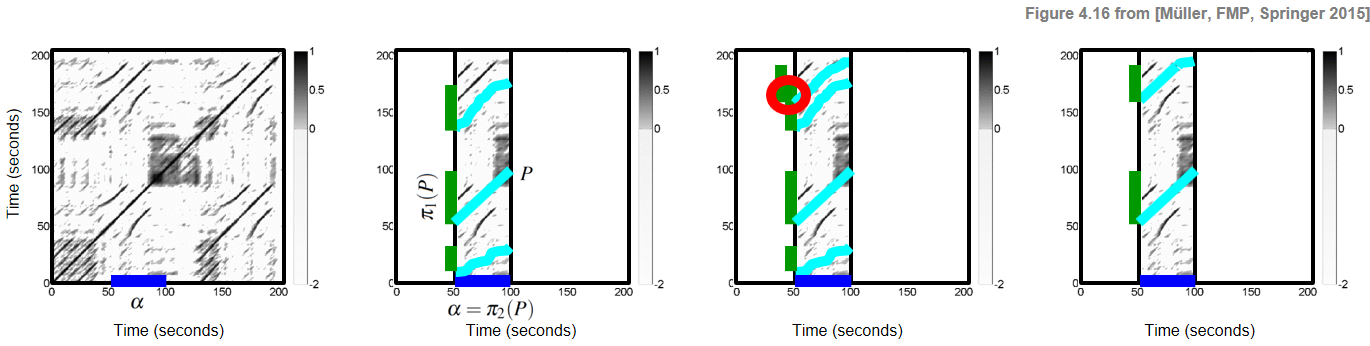

In [32]:
ipd.Image("../img/5.music_structure_analysis/FMP_C4_F16.png", width=1000)

## Coverage

## Score and Optimality

## Computation of Optimal Path Families

## Fitness Measure

## Thumbnail Selection

## Examples of Optimal Path Families